#Урок 7. Дектирование объектов

__1) Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?__

R-FCN. Region-based Fully Convolutional Networks (R-FCN) используют архитектуру Faster R-CNN, но только со сверточными нейронными сетями. В отличии от Faster R-CNN обрезка областей не происходит на выходе сети прогнозирования регионов, вместо этого к входу первой сети добавляется сверточный слой для дополнительного извлечения признаков и обрезка областей производится из последнего сверточного слоя. Далее происходит классификация с помощью всего лишь одного или двух сверточных слоев нейронов. Такой подход позволил достичь точности сравнимой с Faster R-CNN при более быстром времени работы.

R-FCN (Region-based Fully Convolutional Network) является
логическим продолжением развития метода Faster R-CNN.
Основная идея R-FCN состоит в том, чтобы на выходе сети
сформировать карты достоверностей принадлежности
допустимым классам, которые чувствительны
к расположению областей возможного наличия объектов
(position-sensitive score maps)

![](https://drive.google.com/uc?id=1j1BQ5qc9-EDn6ReNGjeCNina4_BXOXHS)

Схема работы R-FCN:

– Извлечение признаков из исходного изображения
посредством прямого прохода по некоторой сверточной
нейронной сети

– Добавление сверточных слоев и формирование набора карт
достоверностей принадлежности допустимым классам,
которые чувствительны к расположению областей
возможного наличия объектов

    • Количество таких карт – 𝑘2, что отвечает числу относительных
      положений объекта на пространственной сетке 𝑘 × 𝑘, которой
      разбивается каждая область возможного наличия объекта
      (если 𝑘 = 3, то относительные положения «сверху слева», «сверху
      по центру», ..., «снизу справа»)
    • Глубина каждой карты 𝐶 + 1, где 𝐶 – количество категорий объектов
    • Глубина объединенной карты признаков – 𝑘2 (𝐶 + 1)

– Генерация областей возможного наличия объектов
с использованием полностью сверточной RPN

– Объединение карт достоверностей в соответствии
с относительным положением в области (position-sensitive
RoI pooling layer)

    • В соответствии с расположением области вырезается
      соответствующая часть набора карт признаков, отвечающих
      относительным позициям объекта
    • Полученные карты реорганизуются в соответствии
      с относительными позициями

– Классификация областей с помощью softmax-
классификатора. Вход классификатора – вектор
достоверностей принадлежности области каждому из
допустимых классов, полученный посредством голосования.

__2) Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.__ 

In [2]:
#Импорт необходимых библиотек
############################################
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

In [1]:
# Монтируем ГуглДиск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH_image = '/content/drive/MyDrive/Нейронные сети/'#800-600_image_1.jpg'

In [4]:
#!wget 'https://drive.google.com/uc?export=download&id=1mmjZJLsFzbBCskpWHtN1qhz6EUP-KMU2' -O people_picture.jpg

In [5]:
# выводим картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpeg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [6]:
# Возвращаем рамки для объектов
#######################################
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [7]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

In [8]:
# Загрузка детектора
#############################
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
# Обработка изображения для передачи в детектор:
#################################################
# Формируем тензор
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [10]:
# Выполняем детектор
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=20)

  display_image(image_with_boxes)
  return result

In [11]:
# Чтение имен кадров 
import os, fnmatch
root_path = PATH_image
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]

array('/content/drive/MyDrive/Нейронные сети/800-600_image_1.jpg',
      dtype='<U57')

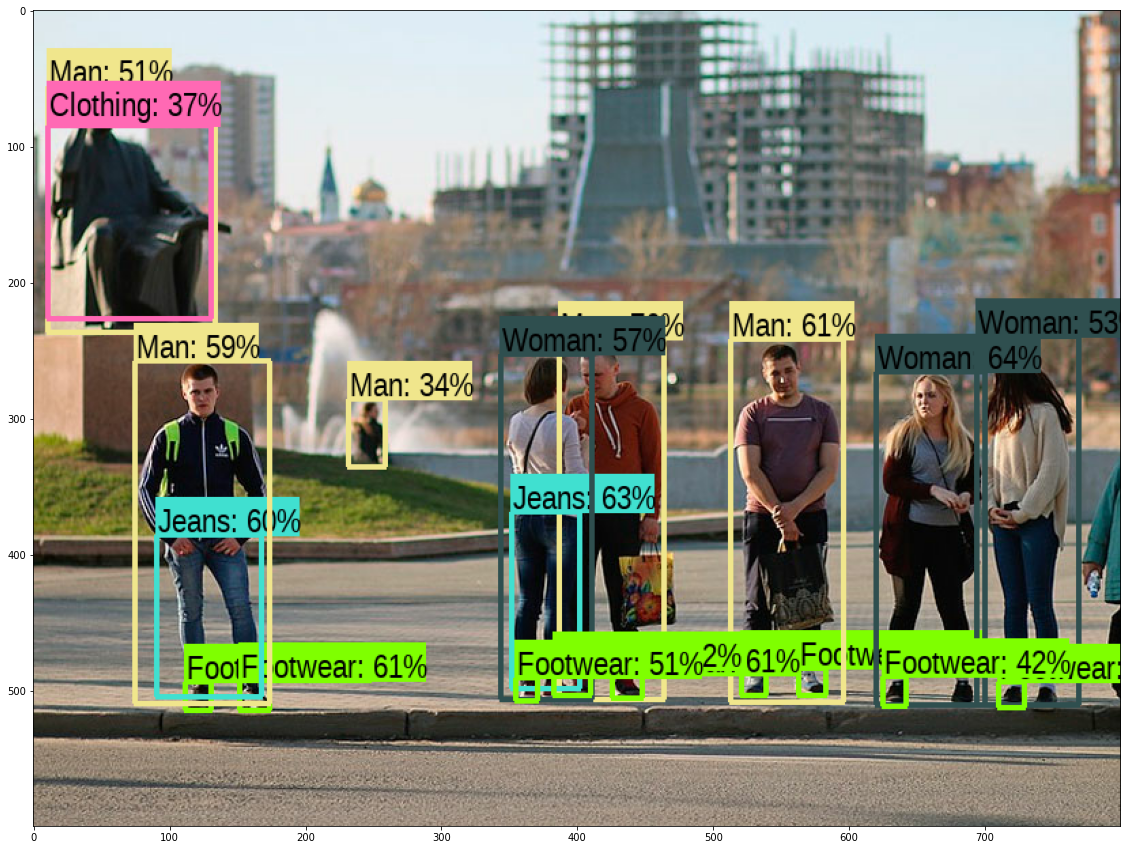

In [12]:
# Проверяем детектор
result = run_detector(detector, List_name[0])

In [13]:
result

{'detection_boxes': array([[0.40355113, 0.48319992, 0.84494334, 0.5805168 ],
        [0.8081057 , 0.6507514 , 0.8395136 , 0.6746012 ],
        [0.8073112 , 0.702603  , 0.8385674 , 0.7295172 ],
        [0.82333916, 0.1389954 , 0.85705507, 0.16392076],
        [0.4436531 , 0.77444947, 0.8501832 , 0.875724  ],
        [0.61602896, 0.43993655, 0.8315065 , 0.5031081 ],
        [0.4034736 , 0.6407084 , 0.84726465, 0.74521965],
        [0.8229425 , 0.18938005, 0.85718566, 0.2185862 ],
        [0.8164014 , 0.5316089 , 0.84307134, 0.5606197 ],
        [0.643745  , 0.11269727, 0.8405136 , 0.21067564],
        [0.43039176, 0.09273161, 0.8489368 , 0.21833624],
        [0.4223624 , 0.42988417, 0.8443384 , 0.5146139 ],
        [0.40036634, 0.8666961 , 0.85151136, 0.96176726],
        [0.80844635, 0.4785792 , 0.8398018 , 0.5125696 ],
        [0.09369234, 0.01289137, 0.39467   , 0.16827038],
        [0.8183379 , 0.44307148, 0.84551096, 0.4648366 ],
        [0.82379836, 0.8862541 , 0.85493016, 0.911762

In [14]:
# Загрузка детектора №2
#############################
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector_2 = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


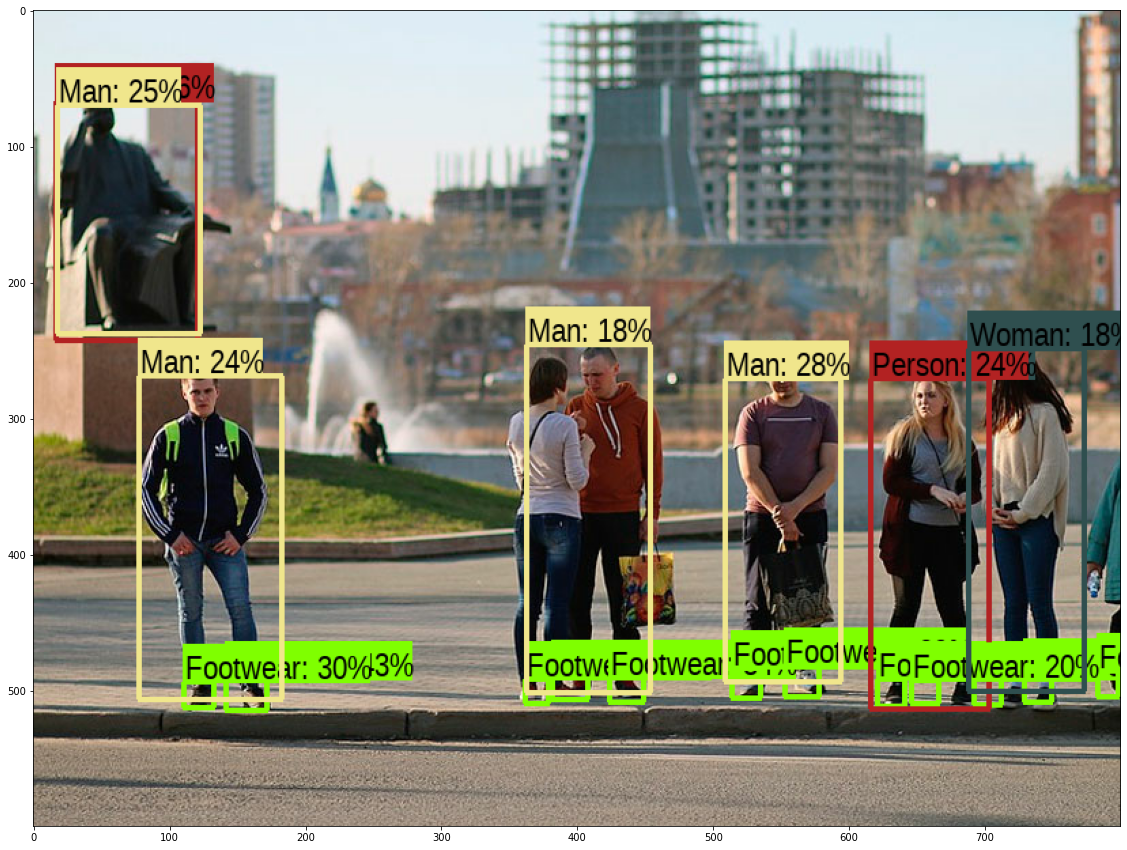

In [15]:
# Проверяем детектор
result_2 = run_detector(detector_2, List_name[0])

In [16]:
result_2

{'detection_boxes': array([[0.8213058 , 0.17748429, 0.8571989 , 0.21548079],
        [0.8186657 , 0.4774195 , 0.8449622 , 0.5110486 ],
        [0.81804186, 0.91083694, 0.8475632 , 0.9372344 ],
        [0.821317  , 0.45165908, 0.84852487, 0.4741984 ],
        [0.45233047, 0.76968074, 0.8556603 , 0.87891555],
        [0.81881714, 0.52894706, 0.84767485, 0.5620678 ],
        [0.82085997, 0.8649    , 0.85102373, 0.8907565 ],
        [0.8082651 , 0.6421608 , 0.8421987 , 0.66932106],
        [0.82387674, 0.13750811, 0.85429585, 0.16657998],
        [0.803395  , 0.6903207 , 0.84073573, 0.723527  ],
        [0.82102334, 0.7760283 , 0.85196793, 0.80163014],
        [0.4521247 , 0.6355848 , 0.8225242 , 0.74290115],
        [0.11208591, 0.02063157, 0.40486088, 0.1518409 ],
        [0.11789663, 0.02133621, 0.39553148, 0.15452568],
        [0.45233047, 0.76968074, 0.8556603 , 0.87891555],
        [0.4492888 , 0.09636522, 0.8445776 , 0.2290155 ],
        [0.8113946 , 0.97781575, 0.84160364, 0.998277

__Вывод:__

Детектор "faster_rcnn" определил гораздо больше объектов чем детектор "ssd/mobilenet_v2/1", но с другой стороны "mobilenet" отработал гораздо быстрее чем "faster_rcnn".

При этом и тот, и другой почему-то опознали памятник на заднем плане как человека...